# Jaguar Re-Identification Baseline with MegaDescriptor and ArcFace

This notebook demonstrates a complete pipeline for training a jaguar re-identification model using MegaDescriptor embeddings and ArcFace loss. The goal is to learn embeddings that place images of the same jaguar close together and images of different jaguars far apart.

## Overview

1. **Data Loading**: Load training images and create a stratified train/validation split
2. **MegaDescriptor**: Extract baseline embeddings using a pre-trained vision transformer
3. **Visualization**: Use MDS to visualize embeddings before and after fine-tuning
4. **ArcFace Training**: Fine-tune embeddings using angular margin loss
5. **Submission**: Generate predictions for the competition test set

## Key Concepts

**MegaDescriptor** is a vision transformer trained on wildlife re-identification datasets. It produces 1536-dimensional embeddings that capture visual features useful for distinguishing individual animals.

**ArcFace (Additive Angular Margin Loss)** is a metric learning technique that:
- Projects embeddings onto a unit hypersphere (L2 normalized)
- Optimizes angular distances between class centers
- Adds an angular margin to improve class separation

The combination allows us to fine-tune MegaDescriptor for our specific jaguar dataset.

## 1. Setup and Configuration

In [1]:
from setup import Env

EXPERIMENT_NAME = "megadescriptor-arcface-local"

env = Env(EXPERIMENT_NAME)

Environment loaded. Project path: /sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification


In [2]:
import os

os.environ['PYTHONHASHSEED'] = str(51)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import wandb

from src.datasets import EmbeddingDataset, ImageDataset
from src.models import (
    MegaDescriptorL384,
    ArcFaceModel
)
from src.submission import prepare_submission_file
from src.training import train_loop
from src.utils import (
    get_device,
    set_seeds,
    create_stratified_split,
    get_embeddings,
    get_train_df,
    get_identity_counts,
    create_deterministic_training_dataloader,
)
from src.visualization import (
    visualize_train_val_distribution,
    visualize_identity_distribution,
    visualize_embeddings_mds,
    visualize_nearest_neighbors,
    visualize_training_history
)
from src.wandb import (
    log_train_val_distribution,
    add_model_artifact,
    add_submission_artifact
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")

All random seeds set to 42 for reproducibility
PyTorch version: 2.9.1+cu128


In [3]:
device = get_device()
print(f"Device: {device}")

Using CUDA GPU
Device: cuda


In [4]:
# Configuration
config = {   
    # Model
    "megadescriptor_model": MegaDescriptorL384.get_model_name(),
    "input_size": MegaDescriptorL384.get_input_size(),
    "embedding_dim": 256,
    "hidden_dim": 512,
    
    # ArcFace
    "arcface_margin": 0.5,
    "arcface_scale": 64.0,
    "dropout": 0.3,
    
    # Training
    "batch_size": 32,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 50,
    "patience": 10,
    "val_split": 0.2,
    
    # Reproducibility
    "seed": RANDOM_SEED,
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  megadescriptor_model: hf-hub:BVRA/MegaDescriptor-L-384
  input_size: 384
  embedding_dim: 256
  hidden_dim: 512
  arcface_margin: 0.5
  arcface_scale: 64.0
  dropout: 0.3
  batch_size: 32
  learning_rate: 0.0001
  weight_decay: 0.0001
  num_epochs: 50
  patience: 10
  val_split: 0.2
  seed: 42


In [5]:
# Initialize Weights and Biases for experiment tracking
# Key hyperparameters are tracked explicitly for easy filtering in W&B dashboard
wandb.login(key=env.WANDB_API_KEY)

wandb.init(
    project=env.WANDB_PROJECT,
    config=config,
    name=EXPERIMENT_NAME,
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /sc/home/karl.schuetz/.netrc
wandb: Currently logged in as: karl-schuetz (karl-schuetz-hasso-plattner-institut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 2. Load and Prepare Data

We load the training data from `train.csv` which contains image filenames and their corresponding jaguar identity labels. The key challenge is creating a proper train/validation split:

**Stratified Split**: We ensure every jaguar identity appears in both the training and validation sets. This is critical because:
1. The model must learn to recognize all individuals during training
2. Validation mAP should reflect performance across all identities
3. Identities with few images still need representation in both sets

In [6]:
train_df = get_train_df(env.DATA_PATH / "train.csv")
identity_counts = get_identity_counts(train_df)

Training dataset:
  Total images: 1895
  Unique identities: 31

Sample rows:
         filename ground_truth  label_encoded
0  train_0001.png        Abril              0
1  train_0002.png        Abril              0
2  train_0003.png        Abril              0
3  train_0004.png       Akaloi              1
4  train_0005.png       Akaloi              1

Identity distribution:
  Min images per identity: 13 (Ipepo)
  Max images per identity: 183 (Marcela)
  Mean images per identity: 61.1


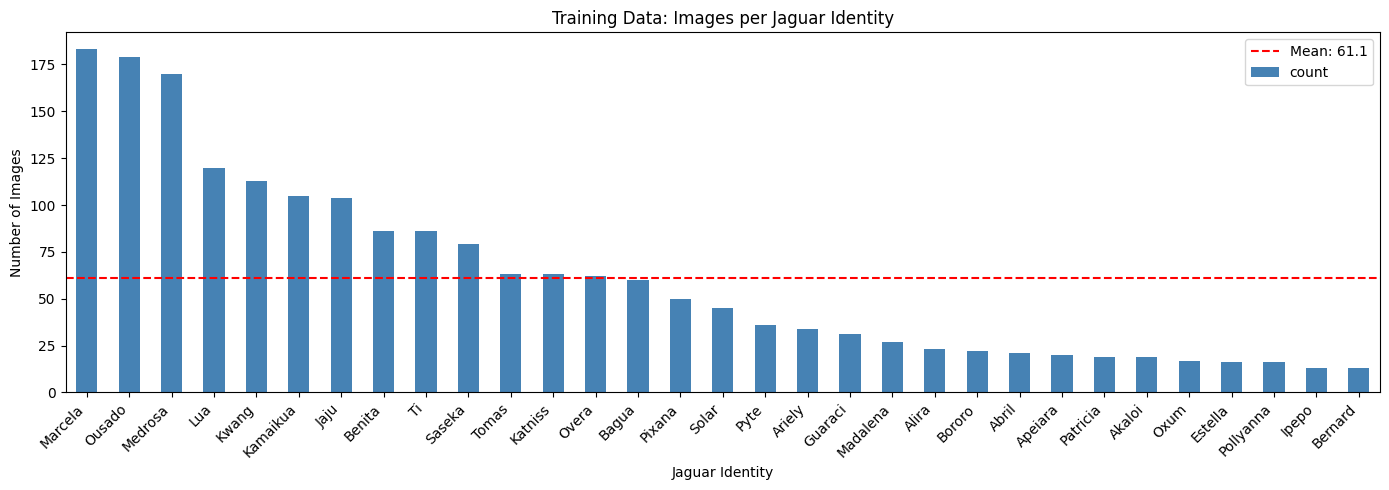

In [7]:
fig = visualize_identity_distribution(identity_counts)

Dataset split:
  Training:   1516 images (80%)
  Validation: 379 images (20%)

Identity coverage:
  Identities in training:   31
  Identities in validation: 31
  Overlap: 31


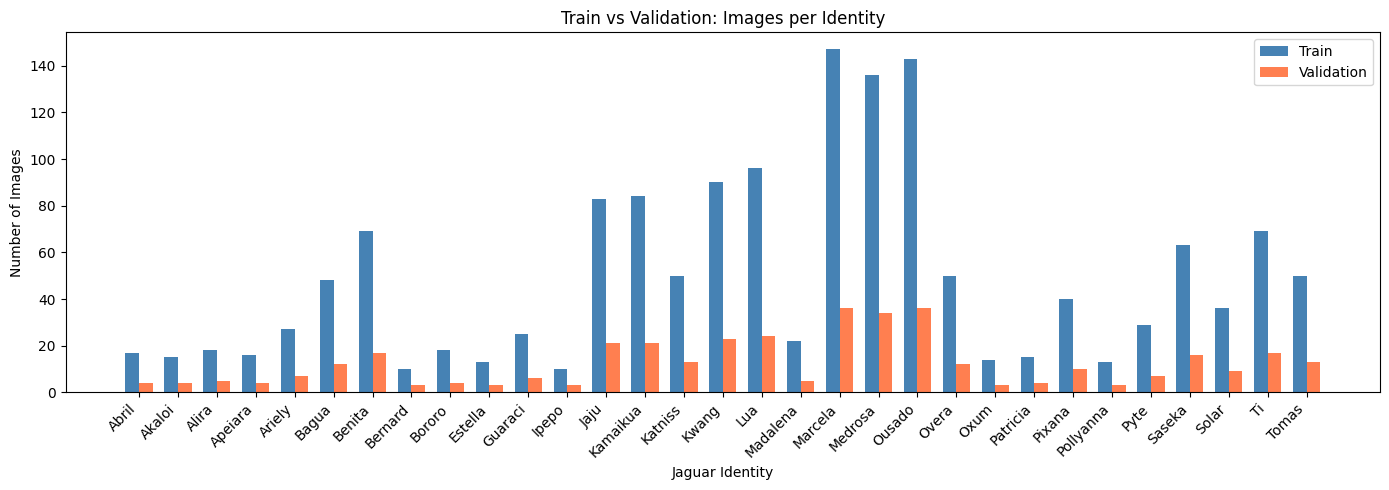


Logged identity distributions to W&B
  Train samples per identity: 10 - 147 (mean: 48.9)
  Val samples per identity: 3 - 36 (mean: 12.2)


In [8]:
# Stratified split: each identity's images are split proportionally
train_data, val_data = create_stratified_split(
    train_df,
    test_size=config['val_split'],
    random_state=config['seed']
)

# Log identity distributions to W&B
train_counts = train_data['ground_truth'].value_counts().sort_index()
val_counts = val_data['ground_truth'].value_counts().sort_index()

fig = visualize_train_val_distribution(train_counts, val_counts)
log_train_val_distribution(train_data, val_data, train_counts, val_counts)


## 3. Load MegaDescriptor Model

MegaDescriptor is a Vision Transformer (ViT-L/14) trained specifically for wildlife re-identification. It was trained on multiple species datasets and produces 1536-dimensional embeddings.

We use the `timm` library to load the pre-trained model from Hugging Face Hub.

In [9]:
# Load MegaDescriptor model
print("Loading MegaDescriptor-L-384 model...")
megadescriptor = MegaDescriptorL384()
megadescriptor.to(device)
megadescriptor_dim = megadescriptor.get_embedding_size()
megadescriptor.print_model_summary()


Loading MegaDescriptor-L-384 model...
Model loaded successfully
  Parameters: 195,198,516
  Embedding dimension: 1536


In [10]:
preprocess = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [11]:
# Extract baseline embeddings for training data
train_filenames = train_data["filename"].astype(str).tolist()
train_image_paths = [env.DATA_PATH / "train" / fn for fn in train_filenames]

train_dataset = ImageDataset(
    train_image_paths,
    train_data['label_encoded'].values
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=False,  # No shuffling for embedding extraction
    num_workers=4,
)

baseline_train_embeddings = get_embeddings(
    megadescriptor,
    preprocess,
    train_dataloader,
    device,
    cache_path = env.EMBEDDINGS_PATH / "baseline_train_embeddings.npz",
)


Loaded cached embeddings from /sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/checkpoints/megadescriptor-arcface-local/embeddings/baseline_train_embeddings.npz
Embeddings shape: (1516, 1536)


/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Visualize Baseline Embeddings with MDS

Multidimensional Scaling (MDS) projects high-dimensional embeddings to 2D while preserving pairwise distances. For embeddings on a hypersphere (L2-normalized), we use geodesic distances (arc length) rather than Euclidean distances.

This visualization shows how well MegaDescriptor separates different jaguars before any fine-tuning.

/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


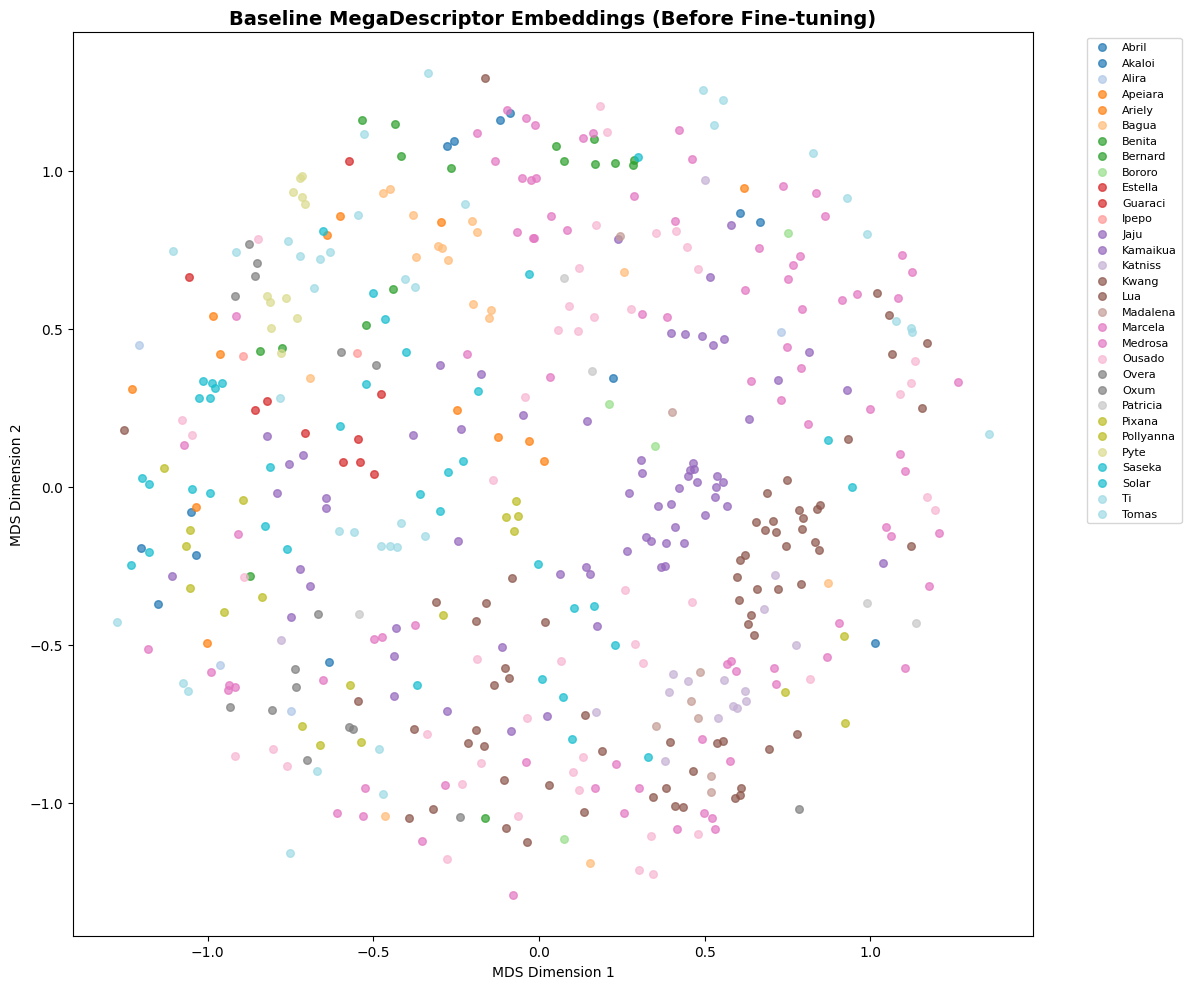

In [12]:
# Visualize baseline embeddings
train_labels = train_data['ground_truth'].values

fig_baseline = visualize_embeddings_mds(
    baseline_train_embeddings,
    train_labels,
    "Baseline MegaDescriptor Embeddings (Before Fine-tuning)",
    config["seed"],
    log_name="baseline_embeddings_mds"
)


## 5. Define Model Architecture

We define two components:

1. **EmbeddingProjection**: Projects 1536-dim MegaDescriptor embeddings to 256-dim. This learned projection optimizes the embedding space for our specific jaguar dataset.

2. **ArcFaceLayer**: Implements Additive Angular Margin Loss. It:
   - Normalizes embeddings to unit length (projects to hypersphere)
   - Computes cosine similarity to class weight vectors
   - Adds angular margin to the ground truth class before softmax
   - Scales logits to sharpen the distribution

## 6. Prepare DataLoaders

We create PyTorch datasets from the pre-computed MegaDescriptor embeddings. This is more efficient than loading images during training since embedding extraction is the bottleneck.

In [14]:
# Extract embeddings for validation set
val_image_paths = [
    env.DATA_PATH / "train" / filename 
    for filename in val_data['filename'].values
]

val_dataset = ImageDataset(
    val_image_paths,
    val_data['label_encoded'].values
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=False,  # No shuffling for embedding extraction
    num_workers=4,
)

print(f"Extracting embeddings for {len(val_image_paths)} validation images...")
baseline_val_embeddings = get_embeddings(
    megadescriptor,
    None,
    val_dataloader,
    device,
    cache_path=env.EMBEDDINGS_PATH / "baseline_val_embeddings.npz",
)

print(f"Validation embeddings shape: {baseline_val_embeddings.shape}")

Extracting embeddings for 379 validation images...
Loaded cached embeddings from /sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/checkpoints/megadescriptor-arcface-local/embeddings/baseline_val_embeddings.npz
Embeddings shape: (379, 1536)
Validation embeddings shape: (379, 1536)


/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
# Create datasets
train_dataset = EmbeddingDataset(
    baseline_train_embeddings, 
    train_data['label_encoded'].values
)
val_dataset = EmbeddingDataset(
    baseline_val_embeddings, 
    val_data['label_encoded'].values
)

# Create dataloaders
# Note: pin_memory=False for MPS compatibility
train_loader = create_deterministic_training_dataloader(
    train_dataset, 
    batch_size=config["batch_size"], 
    shuffle=True,
    num_workers=0,
    pin_memory=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["batch_size"], 
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {config['batch_size']}")

DataLoaders created:
  Train batches: 48
  Val batches: 12
  Batch size: 32


## 7. Training Setup

We set up:
- **CrossEntropyLoss**: Standard classification loss (ArcFace returns logits)
- **AdamW optimizer**: Adam with decoupled weight decay
- **ReduceLROnPlateau scheduler**: Reduces learning rate when validation loss plateaus
- **Early stopping**: Stops training when no improvement for `patience` epochs

We also define a function to compute validation mAP, which simulates the competition metric on the validation set.

In [17]:
num_classes = train_data['label_encoded'].nunique()

# Setup training components
criterion = nn.CrossEntropyLoss()

In [18]:
def train():
    global best_val_loss
    wandb.init()

    config = wandb.config

    lr = config.learning_rate
    batch_size = config.batch_size
    weight_decay = config.weight_decay
    hidden_dim = config.hidden_dim
    embedding_dim = config.embedding_dim
    arcface_margin = config.arcface_margin
    arcface_scale = config.arcface_scale
    
    model = ArcFaceModel(
        input_dim=megadescriptor_dim,
        num_classes=num_classes,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        margin=arcface_margin,
        scale=arcface_scale,
    ).to(device)
    
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=5,
    )

    checkpoint_path = env.CHECKPOINT_PATH / "arcface_best.pth"

    history, best_epoch = train_loop(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        scheduler,
        checkpoint_path,
        device,
        config,
    )

In [24]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "best_val_loss",
        "goal": "minimize"
    },
    "parameters": {
        "learning_rate": {
            "min": 1e-4,
            "max": 1e-1
        },
        "batch_size": {
            "values": [16, 32, 64]
        },
        "hidden_dim": {
            "values": [128, 256, 512, 1024, 2048]
        },
        "embedding_dim": {
            "values": [128, 256, 512]
        },
        "arcface_margin": {
            "min": 0.1,
            "max": 1.0,
        },
        "arcface_scale": {
            "min": 16.0,
            "max": 128.0,
        },
        "weight_decay": {
            "min": 1e-5,
            "max": 1e-3,
        },
        "num_epochs": {
            "values": [50]
        }
    }
}

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x767ee11a8090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 767d90855510, raw_cell="sweep_config = {
    "method": "bayes",
    "metri.." transformed_cell="sweep_config = {
    "method": "bayes",
    "metri.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22677832392e6870632e7363692e6870692e6465222c2275736572223a226b61726c2e7363687565747a227d/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/notebooks/megadescriptor-arcfaceloss-sweep.ipynb#X32sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


AlreadyJoinedError: 

Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x767ee11a8090>> (for post_run_cell), with arguments args (<ExecutionResult object at 767d90855a90, execution_count=24 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 767d90855510, raw_cell="sweep_config = {
    "method": "bayes",
    "metri.." transformed_cell="sweep_config = {
    "method": "bayes",
    "metri.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22677832392e6870632e7363692e6870692e6465222c2275736572223a226b61726c2e7363687565747a227d/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/notebooks/megadescriptor-arcfaceloss-sweep.ipynb#X32sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


AlreadyJoinedError: 

In [25]:
sweep_id = wandb.sweep(sweep_config, project=env.WANDB_PROJECT)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x767ee11a8090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 767d917d2050, raw_cell="sweep_id = wandb.sweep(sweep_config, project=env.W.." transformed_cell="sweep_id = wandb.sweep(sweep_config, project=env.W.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22677832392e6870632e7363692e6870692e6465222c2275736572223a226b61726c2e7363687565747a227d/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/notebooks/megadescriptor-arcfaceloss-sweep.ipynb#X33sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


AlreadyJoinedError: 

Create sweep with ID: vpfcxar0
Sweep URL: https://wandb.ai/karl-schuetz-hasso-plattner-institut/jaguar-reidentification/sweeps/vpfcxar0
Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x767ee11a8090>> (for post_run_cell), with arguments args (<ExecutionResult object at 767d6cb75b10, execution_count=25 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 767d917d2050, raw_cell="sweep_id = wandb.sweep(sweep_config, project=env.W.." transformed_cell="sweep_id = wandb.sweep(sweep_config, project=env.W.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22677832392e6870632e7363692e6870692e6465222c2275736572223a226b61726c2e7363687565747a227d/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/notebooks/megadescriptor-arcfaceloss-sweep.ipynb#X33sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


AlreadyJoinedError: 

In [26]:
wandb.agent(sweep_id, function=train, count=10)

Error in callback <bound method _WandbInit._pre_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x767ee11a8090>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 767d6ceaded0, raw_cell="wandb.agent(sweep_id, function=train, count=10)" transformed_cell="wandb.agent(sweep_id, function=train, count=10)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22677832392e6870632e7363692e6870692e6465222c2275736572223a226b61726c2e7363687565747a227d/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/notebooks/megadescriptor-arcfaceloss-sweep.ipynb#X34sdnNjb2RlLXJlbW90ZQ%3D%3D>,),kwargs {}:


AlreadyJoinedError: 

wandb: ERROR Run 39j2ue54 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 289, in _run_job
wandb: ERROR     wandb.teardown()
wandb: ERROR   File "/sc/home/karl.schuetz/.local/share/uv/python/cpython-3.11.14-linux-x86_64-gnu/lib/python3.11/contextlib.py", line 81, in inner
wandb: ERROR     return func(*args, **kwds)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/sdk/wandb_setup.py", line 589, in teardown
wandb: ERROR     orig_singleton._teardown(exit_code=exit_code)
wandb: ERROR   File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/sdk/wandb_setup.py", line 371, in _teard

Starting training for 50 epochs...

Epoch 1/50


Traceback (most recent call last):                                               
  File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 296, in _run_job
    self._function()
  File "/tmp/ipykernel_155733/1930504405.py", line 39, in train
    history, best_epoch = train_loop(
                          ^^^^^^^^^^^
  File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/src/training/training.py", line 273, in train_loop
    if patience_counter >= config['patience']:
                           ~~~~~~^^^^^^^^^^^^
  File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'patience'



  Train Loss: 67.1277 | Train Acc: 1.3%
  Val Loss:   46.6604 | Val Acc:   4.7%
  Val mAP:    0.3762 | LR: 6.33e-02
  [New best model saved]


epoch,▁
learning_rate,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
val_map,▁
epoch,1
learning_rate,0.06329
train_acc,1.2533
train_loss,67.12767


wandb: ERROR Run mpiw5car errored: 'patience'
wandb: Agent Starting Run: nmoxtnip with config:
wandb: 	arcface_margin: 0.1051358520404147
wandb: 	arcface_scale: 25.321873789604275
wandb: 	batch_size: 64
wandb: 	embedding_dim: 128
wandb: 	hidden_dim: 512
wandb: 	learning_rate: 0.09581407050708315
wandb: 	num_epochs: 50
wandb: 	weight_decay: 0.0004282226857479561
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.


Starting training for 50 epochs...

Epoch 1/50


Traceback (most recent call last):                                                
  File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/agents/pyagent.py", line 296, in _run_job
    self._function()
  File "/tmp/ipykernel_155733/1930504405.py", line 39, in train
    history, best_epoch = train_loop(
                          ^^^^^^^^^^^
  File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/src/training/training.py", line 273, in train_loop
    if patience_counter >= config['patience']:
                           ~~~~~~^^^^^^^^^^^^
  File "/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
           ~~~~~~~~~~~^^^^^
KeyError: 'patience'



  Train Loss: 4.4981 | Train Acc: 32.4%
  Val Loss:   2.2427 | Val Acc:   59.1%
  Val mAP:    0.4224 | LR: 9.58e-02
  [New best model saved]


epoch,▁
learning_rate,▁
train_acc,▁
train_loss,▁
val_acc,▁
val_loss,▁
val_map,▁
epoch,1
learning_rate,0.09581
train_acc,32.38786
train_loss,4.4981


wandb: ERROR Run nmoxtnip errored: 'patience'
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x767ee11a8090>> (for post_run_cell), with arguments args (<ExecutionResult object at 767d6ced6a10, execution_count=26 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 767d6ceaded0, raw_cell="wandb.agent(sweep_id, function=train, count=10)" transformed_cell="wandb.agent(sweep_id, function=train, count=10)
" store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell://ssh-remote%2B7b22686f73744e616d65223a22677832392e6870632e7363692e6870692e6465222c2275736572223a226b61726c2e7363687565747a227d/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/notebooks/megadescriptor-arcfaceloss-sweep.ipynb#X34sdnNjb2RlLXJlbW90ZQ%3D%3D> result=None>,),kwargs {}:


AlreadyJoinedError: 

## 8. Training Loop

We train the model with:
- Validation loss and mAP computed each epoch
- Best model checkpointed based on lowest validation loss
- Early stopping if no improvement for `patience` epochs
- All metrics logged to Weights and Biases

## 9. Visualize Fine-tuned Embeddings

After training, we visualize the fine-tuned embeddings using MDS and compare them to the baseline. We expect to see tighter clusters for each identity after ArcFace training.

In [ ]:
# Load best model
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint_path}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val mAP: {checkpoint['val_map']:.4f}")

Loaded best model from epoch /sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/checkpoints/megadescriptor-arcface-local
  Val Loss: 4.5350
  Val mAP: 0.7762


In [19]:
# Extract fine-tuned embeddings for training data
model.eval()
with torch.no_grad():
    train_tensor = torch.FloatTensor(baseline_train_embeddings).to(device)
    finetuned_train_embeddings = model.get_embeddings(train_tensor).cpu().numpy()

print(f"Fine-tuned embeddings shape: {finetuned_train_embeddings.shape}")
print(f"Mean L2 norm: {np.linalg.norm(finetuned_train_embeddings, axis=1).mean():.4f}")

Fine-tuned embeddings shape: (1516, 256)
Mean L2 norm: 1.0000


/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:744: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9. To suppress this warning, provide some value of `n_init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:754: FutureWarning: The default value of `init` will change from 'random' to 'classical_mds' in 1.10. To suppress this warning, provide some value of `init`.
  warnings.warn(
/sc/home/karl.schuetz/hands_on_computer_vision/Kaggle-Competition-Jaguar-Re-identification/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:771: FutureWarning: The `dissimilarity` parameter is deprecated and will be removed in 1.10. Use `metric` instead.
  warnings.warn(


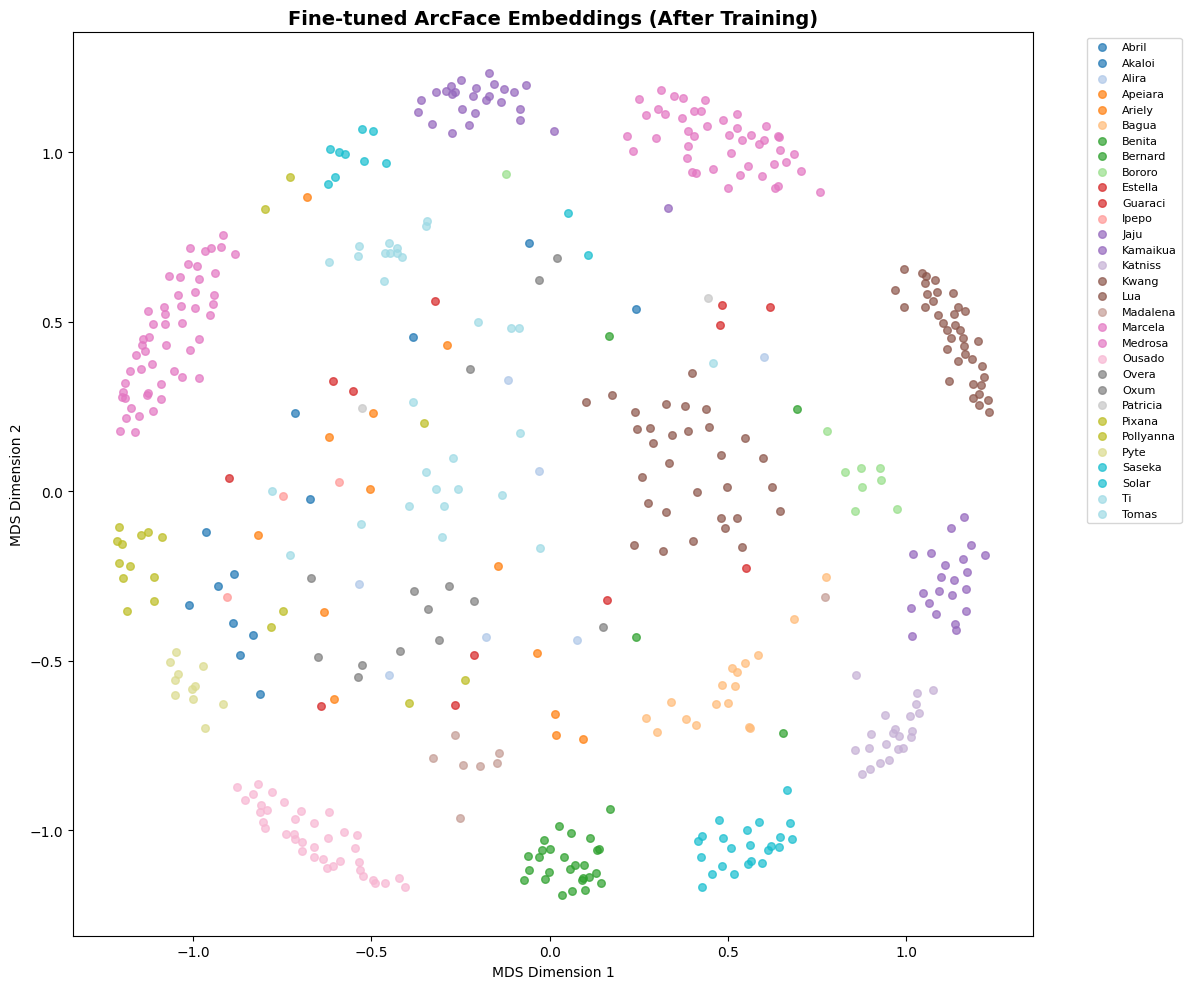

In [ ]:
# Visualize fine-tuned embeddings
fig_finetuned = visualize_embeddings_mds(
    finetuned_train_embeddings,
    train_labels,
    "Fine-tuned ArcFace Embeddings (After Training)",
    config["seed"],
    log_name="finetuned_embeddings_mds"
)

In [21]:
# Visualize nearest neighbors for a few validation examples
# We'll pick a random sample and also manually select interesting cases

print("Generating nearest neighbor visualizations for validation set...")
print(f"Validation set size: {len(val_data)}")

# Get validation embeddings (we already have these)
# baseline_val_embeddings (original MegaDescriptor)
# val_finetuned_embeddings (fine-tuned with ArcFace)

# Extract fine-tuned embeddings for validation set if not already done
model.eval()
with torch.no_grad():
    val_tensor = torch.FloatTensor(baseline_val_embeddings).to(device)
    val_finetuned_embeddings = model.get_embeddings(val_tensor).cpu().numpy()

print(f"Original embeddings shape: {baseline_val_embeddings.shape}")
print(f"Fine-tuned embeddings shape: {val_finetuned_embeddings.shape}")

# Create list of validation image paths
val_labels = val_data['ground_truth'].values

# Build list of validation image paths
val_image_paths = [
    env.DATA_PATH / "train" / filename 
    for filename in val_data['filename'].values
]

print(f"Number of validation images: {len(val_image_paths)}")

Generating nearest neighbor visualizations for validation set...
Validation set size: 379
Original embeddings shape: (379, 1536)
Fine-tuned embeddings shape: (379, 256)
Number of validation images: 379


Example 1: Random query (index 102)


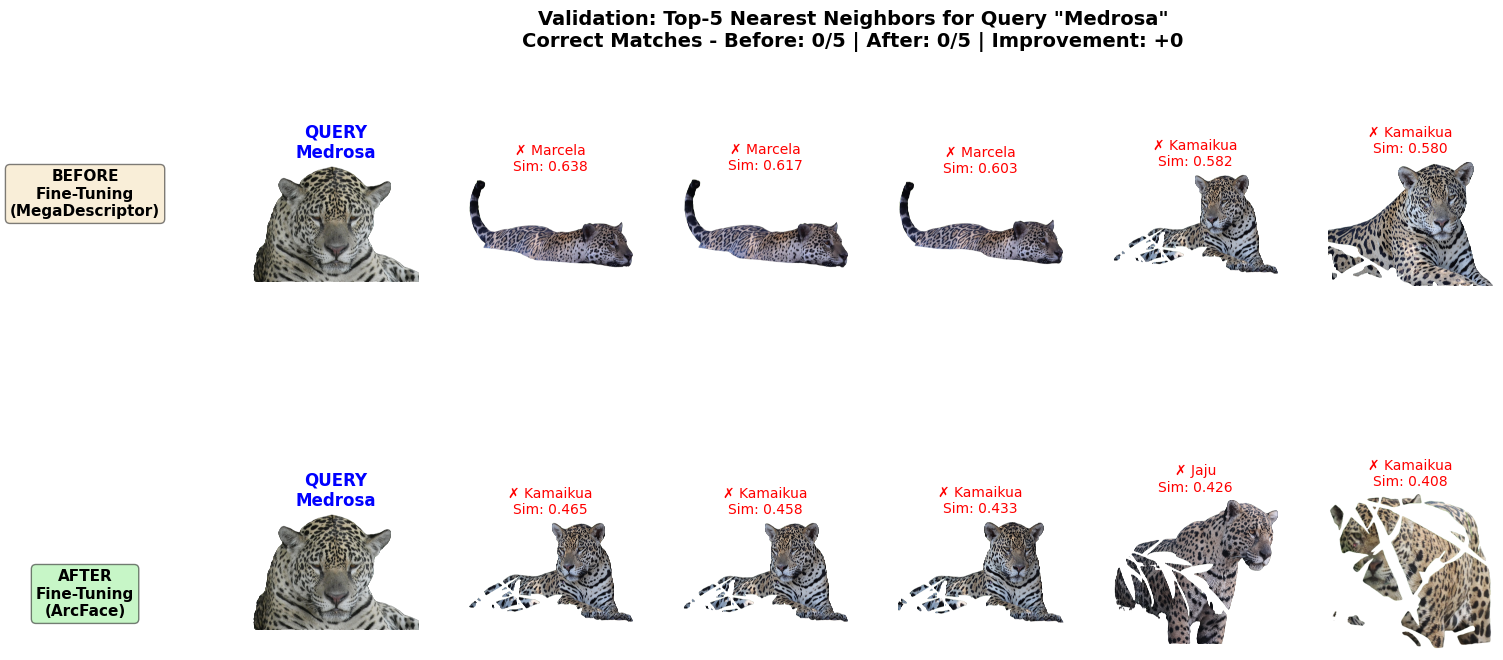

In [ ]:
# Example 1: Random validation image
np.random.seed(RANDOM_SEED)
random_idx = np.random.randint(0, len(val_labels))

print(f"Example 1: Random query (index {random_idx})")
fig1, stats1 = visualize_nearest_neighbors(
    query_idx=random_idx,
    original_embeddings=baseline_val_embeddings,
    finetuned_embeddings=val_finetuned_embeddings,
    image_paths=val_image_paths,
    labels=val_labels,
    k=5
)

## 10. Generate Competition Submission

Now we generate predictions for the test set. The competition expects:
- A CSV with columns: `row_id`, `similarity`
- Each row corresponds to a query-gallery image pair from `test.csv`
- `similarity` is a float between 0 and 1

We:
1. Extract MegaDescriptor embeddings for all test images
2. Project through our fine-tuned model
3. Compute cosine similarity for each pair in `test.csv`
4. Clip values to [0, 1] and save as CSV

In [ ]:
combined_models = nn.Sequential(
    megadescriptor,
    model
)

submission_path = env.CHECKPOINT_PATH / "submission.csv"

prepare_submission_file(
    model=combined_models,
    data_path=env.DATA_PATH,
    submission_path=submission_path,
    device=device,
    batch_size=config["batch_size"],
)

Test pairs to score: 137270
Columns: ['row_id', 'query_image', 'gallery_image']

Sample rows:
   row_id    query_image  gallery_image
0       0  test_0001.png  test_0002.png
1       1  test_0001.png  test_0003.png
2       2  test_0001.png  test_0004.png
3       3  test_0001.png  test_0005.png
4       4  test_0001.png  test_0006.png


## 11. Save Artifacts to Weights and Biases

We save the best model checkpoint and this notebook as W&B artifacts for reproducibility.

In [30]:
model_path = env.CHECKPOINT_PATH / "arcface_best.pth"

add_model_artifact(model_path)
add_submission_artifact(submission_path)

Model artifact saved to W&B
Submission artifact saved to W&B


In [ ]:
# Finish W&B run
wandb.finish()
print("W&B run completed")

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
num_identities,▁
train_acc,▁▁▁▁▁▂▂▃▃▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
train_loss,█▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples,▁
val_acc,▁▁▂▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████████████
val_loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_map,▁▂▂▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████████████
val_samples,▁
best_epoch,50


W&B run completed


## Summary

This notebook demonstrated a complete pipeline for jaguar re-identification:

1. **Data Preparation**: Loaded training data and created a stratified train/validation split ensuring all identities appear in both sets.

2. **Baseline Embeddings**: Extracted 1536-dimensional embeddings using MegaDescriptor-L-384, a vision transformer pre-trained for wildlife re-identification.

3. **ArcFace Training**: Fine-tuned embeddings using ArcFace loss, which optimizes angular distances on a hypersphere. This encourages embeddings of the same jaguar to cluster together.

4. **Visualization**: Used MDS to project embeddings to 2D, comparing baseline vs fine-tuned representations.

5. **Submission**: Generated predictions by computing cosine similarity between fine-tuned embeddings for all test pairs.

**Key Hyperparameters**:
- ArcFace margin: 0.5 (adds 28.6 degrees angular penalty)
- ArcFace scale: 64 (controls softmax sharpness)
- Embedding dimension: 256 (projected from 1536)
- Learning rate: 1e-4 with ReduceLROnPlateau scheduler

**Next Steps**:
- Experiment with different margins and scales
- Try data augmentation during training
- Ensemble multiple models
- Fine-tune the MegaDescriptor backbone (more compute required)